In [2]:
%load_ext autoreload
%autoreload 2
import sys
import collections
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import StrMethodFormatter

In [3]:
plt.style.use('default')

In [4]:
def get_x(l, key):
    if key in l[0]:
        return [(i[key] if key in i else -1000) for i in l if check_condition(i)]
    if key.replace('.', '', 1).isnumeric():
        return [float(key) for i in l]
    if key == "":
        return [0 for i in l]
    if "|" in key:
        if key.split("|")[0] == "abs":
            return [abs(i) for i in get_x(l, key.split("|")[1])]
        if key.split("|")[0] == "norm":
            vals = [i for i in get_x(l, key.split("|")[1])]
            min_vals = min(vals)
            max_vals = max(vals)
            return [(i - min_vals) / (max_vals - min_vals) for i in vals]
        raise ValueError("Unknown operator")
    if "%" in key:
        return [
            (i - j) / j
            for i, j in zip(get_x(l,
                                  key.split("%")[0]), get_x(l, "%".join(key.split("%")[1:])))
        ]
    if "/" in key:
        return [
            i / j
            for i, j in zip(get_x(l,
                                  key.split("/")[0]), get_x(l, "/".join(key.split("/")[1:])))
        ]
    if "-" in key:
        return [
            i - j
            for i, j in zip(get_x(l,
                                  key.split("-")[0]), get_x(l, "-".join(key.split("-")[1:])))
        ]
    if "+" in key:
        return [
            i + j
            for i, j in zip(get_x(l,
                                  key.split("+")[0]), get_x(l, "+".join(key.split("+")[1:])))
        ]
    print(key, "absent")
    return [(i[key] if key in i else -10) for i in l if check_condition(i)]


def check_condition(i):
    return True

In [5]:
# from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


def interpolate_points(
    val1, val2, order, label, color, marker=None, ax=None, linestyle="-", linewidth=1, kwargs={}
):
    if ax is None:
        ax = plt

    if order == "nofit":
        return

    # x, y = np.array(val1), np.array(val2)

    # X_Y_Spline = make_interp_spline(x, y)

    # # Returns evenly spaced numbers
    # # over a specified interval.
    # X_ = np.linspace(x.min(), x.max(), 500)
    # Y_ = X_Y_Spline(X_)
    # plt.plot(X_, Y_)
    # return

    if order in ['slinear', 'quadratic', 'cubic'
                ] or (isinstance(order, str) and order.startswith("savgol")):
        try:
            if order.startswith("savgol"):
                x_smooth = savgol_filter(val1, int(order.split("_")[1]), int(order.split("_")[2]))
                x_smooth[0], x_smooth[-1] = val1[0], val1[-1]
                y_smooth = savgol_filter(
                    val2, int(order.split("_")[1]), int(order.split("_")[2]), mode="nearest"
                )
                y_smooth[0], y_smooth[-1] = val2[0], val2[-1]
            else:
                x_smooth = val1
                y_smooth = val2

            points = np.array([x_smooth, y_smooth]).T  # a (nbre_points x nbre_dim) array

            # Linear length along the line:
            distance = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
            distance = np.insert(distance, 0, 0) / distance[-1]

            alpha = np.linspace(0, 1, 75)

            interpolator = interp1d(distance, points, kind=order.split("_")[-1], axis=0)
            curve = interpolator(alpha)

            # Graph:
            ax.plot(
                *curve.T,
                label=label,
                color=color,
                linestyle=linestyle,
                marker=marker,
                markersize=0,
                linewidth=linewidth
            )

            # ax.plot(*points.T, 'ok', label='original points')
            return
        except Exception as exc:
            print(f"Failed for label: {label} because: {exc}")
            order = "connect"

    if order == "inter1":
        x, y = x_smooth, val2
        t = np.arange(len(x))
        ti = np.linspace(0, t.max(), 10 * t.size)

        xi = interp1d(t, x, kind='cubic')(ti)
        yi = interp1d(t, y, kind='cubic')(ti)
        ax.plot(
            xi,
            yi,
            label=label,
            color=color,
            linestyle=linestyle,
            markersize=0,
            linewidth=linewidth
        )
        return

    if order in ["onlyconnect", "connect"]:
        ax.plot(
            val1,
            val2,
            label=label,
            color=color,
            linestyle=linestyle,
            marker=marker,
            markersize=0,
            linewidth=linewidth,
            **kwargs
        )
        return

    get_x1_sorted = np.linspace(min(val1), max(val1), 500000)

    if order in [1, "1", "onlyfit1"]:
        m, b = np.polyfit(val1, val2, 1)
        preds = m * np.array(get_x1_sorted) + b

    elif order in [2, "2"]:
        m2, m1, b = np.polyfit(val1, val2, 2)
        preds = m2 * np.array(get_x1_sorted)**2 + m1 * np.array(get_x1_sorted) + b
    elif order in [3, "3"]:
        m3, m2, m1, b = np.polyfit(val1, val2, 3)
        preds = m3 * np.array(get_x1_sorted)**3 + m2 * np.array(get_x1_sorted)**2 + m1 * np.array(
            get_x1_sorted
        ) + b
    elif order in [4, "4"]:
        m4, m3, m2, m1, b = np.polyfit(val1, val2, 4)
        preds = m4 * np.array(get_x1_sorted)**4 + m3 * np.array(get_x1_sorted)**3 + m2 * np.array(
            get_x1_sorted
        )**2 + m1 * np.array(get_x1_sorted) + b
    elif order in [5, "5"]:
        m5, m4, m3, m2, m1, b = np.polyfit(val1, val2, 5)
        preds = m5 * np.array(get_x1_sorted)**5 + m4 * np.array(get_x1_sorted)**4 + m3 * np.array(
            get_x1_sorted
        )**3 + m2 * np.array(get_x1_sorted)**2 + m1 * np.array(get_x1_sorted) + b
    elif order == "log":
        m1, b = np.polyfit(np.log(val1), val2, 1)
        log_get_x1_sorted = np.log(get_x1_sorted)
        preds = m1 * np.array(log_get_x1_sorted) + b
    elif order == "2log":
        m2, m1, b = np.polyfit(np.log(val1), val2, 2)
        log_get_x1_sorted = np.log(get_x1_sorted)
        preds = m2 * np.array(log_get_x1_sorted)**2 + m1 * np.array(log_get_x1_sorted) + b
    elif order == "3log":
        m3, m2, m1, b = np.polyfit(np.log(val1), val2, 3)
        log_get_x1_sorted = np.log(get_x1_sorted)
        preds = m3 * np.array(log_get_x1_sorted)**3 + m2 * np.array(
            log_get_x1_sorted
        )**2 + m1 * np.array(log_get_x1_sorted) + b
    else:
        assert order in [0, -1, None, "", "0"]

    ax.plot(
        get_x1_sorted,
        preds,
        color=color,
        linestyle=linestyle,
        label=label,
        marker=marker,
        markersize=0,
        linewidth=linewidth
    )

In [6]:
def plot_basic_scatter(
    list_dict_values,
    key_x,
    keys_y,
    labels=None,
    _dict_key_to_label="def",
    colors=None,
    colormaps=None,
    keycolor=None,
    order=0,
    linestyles=None,
    keys_error=None,
    loc="best",
    title=None,
    keyclustering=None,
    kwargs={},
    _dict_key_to_limit={},
    ax1=None,
    lambda_filtering=None,
    markers=None,
    legendtitle=None,
    markersize=12,
    fontsize=None
):
    if ax1 is None:
        fig, ax1 = plt.subplots()
    else:
        fig = None
        ax1 = plt.gca()
    if _dict_key_to_label == "def":
        _dict_key_to_label = dict_key_to_label
    else:
        _dict_key_to_label = {**dict_key_to_label, **_dict_key_to_label}

    if colormaps is None:
        if keycolor is not None:
            colormaps = [
                "Reds", "Blues", "Greens", "Oranges", "Greys", "Purples", "Reds", "Blues", "Greens",
                "Oranges", "Greys", "Purples"
            ][:len(keys_y)]
    else:
        dict_colormaps = create_colormaps()
        colormaps = [dict_colormaps.get(cmp, cmp) for cmp in colormaps]

    if colors is None:
        if colormaps is not None:
            colors = [cm.get_cmap(cmp)(0.5) for cmp in colormaps]
        else:
            colors = cm.rainbow(np.linspace(0, 1, len(keys_y)))

    if lambda_filtering is not None:
        list_dict_values = [lll for lll in list_dict_values if lambda_filtering(lll)]

    if keyclustering is not None:
        list_dict_values_means = lambda_clustering(list_dict_values, keyclustering)

    if "x" in _dict_key_to_limit:
        ax1.set_xlim(_dict_key_to_limit["x"])
    if "y" in _dict_key_to_limit:
        ax1.set_ylim(_dict_key_to_limit["y"])

    for index in range(len(keys_y)):
        key_y = keys_y[index]
        if linestyles is not None:
            linestyle = linestyles[index % len(linestyles)]
        else:
            linestyle = None
        if colormaps is not None:
            colormap = colormaps[index]
        else:
            colormap = None
        if markers is not None:
            marker = markers[index]
        else:
            dictlinestyle_to_marker = {
                None: "o",
                "solid": "o",
                "dashed": "+",
                "dotted": "*",
                "dashdot": "x",
            }
            marker = dictlinestyle_to_marker[linestyle]
        if marker == "no":
            marker = None
        color = colors[index]
        if labels is None:
            label = key_y
        else:
            label = labels[index]
        label = _dict_key_to_label.get(label, label)

        if keys_error is not None:
            # plt.errorbar(
            #     x,
            #     y,
            #     get_x(list_dict_values, keys_error[i]),
            #     color=color,
            #     label=label)
            ax1.fill_between(
                get_x(list_dict_values_means, key_x),
                get_x(list_dict_values_means, key_y + "-" + keys_error[index]),
                get_x(list_dict_values_means, key_y + "+" + keys_error[index]),
                color=color,
                # label=label,
                **kwargs
            )

        if keycolor is not None:
            ax1.scatter(
                get_x(list_dict_values, key_x),
                get_x(list_dict_values, key_y),
                c=get_x(list_dict_values, keycolor),
                cmap=colormap,
                marker=marker,
                label=None if order != "nofit" else label,
                **kwargs
            )
            color = cm.get_cmap(color)(0.5)
        else:
            ax1.scatter(
                get_x(list_dict_values, key_x),
                get_x(list_dict_values, key_y),
                color=color,
                marker=marker,
                s=[markersize for _ in get_x(list_dict_values, key_y)],
                label=None if order != "nofit" else label,
            )
        interpolate_points(
            get_x(list_dict_values, key_x),
            get_x(list_dict_values, key_y),
            order=order,
            ax=ax1,
            label=label,
            color=color,
            marker=marker,
            linestyle=linestyle,
            linewidth=2.5
        )

    ax1.set_xlabel(_dict_key_to_label.get(key_x, key_x), fontsize=SIZE)
    ax1.set_ylabel("Normalized rewards", fontsize=SIZE)
    if loc != "no":
        fontsize = fontsize or SIZE
        if isinstance(loc, tuple):
            legend = ax1.legend(title=legendtitle, bbox_to_anchor=loc, fontsize=fontsize)
        else:
            legend = ax1.legend(title=legendtitle, loc=loc, fontsize=fontsize)
        for lgnd in legend.legendHandles:
            lgnd.set_markersize(8)
    if title:
        ax1.set_title(title, fontsize=SIZE)
    return fig

In [7]:
import matplotlib
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


def get_color_from_cmap(cmp, dict_colormaps):
    cmp = dict_colormaps.get(cmp, cmp)
    if isinstance(cmp, str) and cmp.startswith("fake_"):
        return cmp.split("_")[1]
    return cm.get_cmap(cmp)(0.5)


def create_colormaps():
    N = 256
    dict_colormaps = {}

    def create_cmp(r, g, b):
        np_array = np.ones((N, 4))
        np_array[:, 0] = np.linspace(r / 256, 1, N)
        np_array[:, 1] = np.linspace(g / 256, 1, N)
        np_array[:, 2] = np.linspace(b / 256, 1, N)
        return ListedColormap(np_array)

    dict_colormaps["Yellows"] = create_cmp(255, 232, 11)
    dict_colormaps["Light_Yellows"] = create_cmp(255, 232, 200)
    dict_colormaps["Dark_Blues"] = create_cmp(2, 2, 200)
    dict_colormaps["Blues_Greys"] = create_cmp(40, 60, 80)
    dict_colormaps["Blues_Greens"] = create_cmp(125, 150, 250)
    dict_colormaps["Reds_Greens"] = create_cmp(250, 150, 125)
    dict_colormaps["Dark_Greys"] = create_cmp(40, 60, 200)

    return dict_colormaps

In [20]:
def plot_key(
    l,
    key_x,
    key_y,
    key_y_2=None,
    keysplit=None,
    keycolor=None,
    keysize=None,
    order=1,
    label="",
    labels=None,
    diag=False,
    markers=None,
    colors=None,
    colormaps=None,
    linestyles=None,
    linewidths=None,
    _dict_key_to_limit={},
    _dict_key_to_label="def",
    loc="upper right",
    legendtitle=None,
    lambda_filtering=None,
    keyclustering=None,
    list_indexes=None,
    keyerror=None,
    title=None,
    connect_endpoints=False,
    fig=None,
    fontsize=None,
    kwargs={}
):
    if list_indexes is None:
        list_indexes = [i for i, ll in enumerate(l) if ll is not None]
        if len(list_indexes) == len(l):
            list_indexes = None
    if list_indexes is not None:
        l = [l[i] for i in list_indexes]
        if labels is not None:
            labels = [labels[i] for i in list_indexes]
        if colormaps is not None:
            colormaps = [colormaps[i] for i in list_indexes]
        if colors is not None:
            colors = [colors[i] for i in list_indexes]
        if linestyles is not None:
            linestyles = [linestyles[i] for i in list_indexes]
        if linewidths is not None:
            linewidths = [linewidths[i] for i in list_indexes]
        if markers is not None:
            markers = [markers[i] for i in list_indexes]
    if fig is None:
        fig, ax1 = plt.subplots()
    else:
        ax1 = plt.gca()

    if FORMAT_X:
        if FORMAT_X == 1:
            plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))  # 2 decimal places
        elif isinstance(FORMAT_X, list):
            plt.gca().set_xticks(FORMAT_X)
    if FORMAT_Y:
        assert FORMAT_Y == 3
        plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))  # 2 decimal places
    if _dict_key_to_label == "def":
        _dict_key_to_label = dict_key_to_label
    else:
        _dict_key_to_label = {**dict_key_to_label, **_dict_key_to_label}

    if keysplit is not None:
        assert len(l) == 1
        l = lambda_split(l[0], keysplit, lambda_filtering=lambda_filtering)
        if labels == "fromsplit":
            labels = [label.format(ll[0][keysplit]) for ll in l]

    if colormaps is None:
        if keycolor is not None:
            colormaps = [
                "Reds", "Blues", "Greens", "Oranges", "Greys", "Purples", "Reds", "Blues", "Greens",
                "Oranges", "Greys", "Purples"
            ][:len(l)]
    else:
        dict_colormaps = create_colormaps()
        colormaps = [
            dict_colormaps.get(cmp, cmp) if isinstance(cmp, str) else cmp for cmp in colormaps
        ]

    if colors is None:
        if colormaps is not None:
            colors = [cm.get_cmap(cmp)(0.5) for cmp in colormaps]
        else:
            colors = cm.rainbow(np.linspace(0, 1, len(l)))

    if labels is None:
        if label.startswith("."):
            labels = [".".join([str(ll[0][key]) for key in label.split(".")[1:]]) for ll in l]
        else:
            labels = [label + str(i) for i in range(len(l))]

    plt.xlabel(_dict_key_to_label.get(key_x, key_x), fontsize=SIZE_AXIS)
    plt.ylabel(_dict_key_to_label.get(key_y, key_y), fontsize=SIZE_AXIS)
    if key_y_2:
        ax2 = ax1.twinx()
        ax2.set_ylabel(_dict_key_to_label.get(key_y_2, key_y_2), fontsize=SIZE_AXIS)

    def plot_with_int(ll, color, colormap, label, marker, linestyle, linewidth, key_y, ax, kwargs):
        ll = [lll for lll in ll if lambda_filtering is None or lambda_filtering(lll)]
        t = get_x(ll, key_x)
        if t == []:
            return
        if keyclustering is not None:
            ll = lambda_clustering(ll, keyclustering)

        # if label !="no" else None#
        if keyerror is not None:
            ax.errorbar(
                get_x(ll, key_x),
                get_x(ll, key_y),
                get_x(ll, keyerror),
                color=color,
                label=label,
                marker=marker,
                **kwargs
            )
            plt.fill_between(
                get_x(ll, key_x),
                get_x(ll, key_y + "-" + keyerror),
                get_x(ll, key_y + "+" + keyerror),
                alpha=0.5,
            )
        else:
            if keycolor is not None:
                kwargs["c"] = [-x for x in get_x(ll, keycolor)]
                kwargs["cmap"] = colormap
            else:
                kwargs["color"] = color
            if keysize is not None:
                kwargs["s"] = [x for x in get_x(ll, keysize)]
                min_s = min(kwargs["s"])
                max_s = max(kwargs["s"])
                kwargs["s"] = [200 * (x - min_s) / (max_s - min_s) + 5 for x in kwargs["s"]]

        interpolate_points(
            get_x(ll, key_x),
            get_x(ll, key_y),
            order=order,
            ax=ax,
            label=label,
            color=color,
            marker=marker,
            linewidth=linewidth,
            linestyle=linestyle
        )
        if order not in ["onlyfit1", "onlyconnect"]:
            ax.scatter(
                get_x(ll, key_x),
                get_x(ll, key_y),
                label=None if order != "nofit" else label,
                marker=marker,
                **kwargs
            )

        if connect_endpoints:
            ax.plot(
                get_x([ll[0], ll[-1]], key_x),
                get_x([ll[0], ll[-1]], key_y),
                label=None,
                color=color,
                linestyle="--",
            )

    for index in range(len(l)):
        label = labels[index]
        if linestyles is not None:
            linestyle = linestyles[index % len(linestyles)]
        else:
            linestyle = None
        if colormaps is not None:
            colormap = colormaps[index]
        else:
            colormap = None
        if markers is not None:
            marker = markers[index]
        else:
            dictlinestyle_to_marker = {
                None: "o",
                "solid": "o",
                "dashed": "+",
                "dotted": "*",
                "dashdot": "x",
            }
            marker = dictlinestyle_to_marker[linestyle]
        if marker == "no":
            marker = None
        if linewidths is not None:
            linewidth = linewidths[index]
        else:
            linewidth = None
        kwargs_copy = {k: v for k, v in kwargs.items()}
        plot_with_int(
            l[index],
            color=colors[index],
            colormap=colormap,
            label=label,
            marker=marker,
            linewidth=linewidth,
            linestyle=linestyle,
            key_y=key_y,
            ax=ax1,
            kwargs=kwargs_copy
        )
        if key_y_2:
            plot_with_int(
                l[index],
                color=colors[index],
                colormap=colormap,
                label=label,
                marker="*",
                linestyle="--",
                key_y=key_y_2,
                ax=ax2,
                kwargs=kwargs_copy
            )

    if diag:
        xpoints = ypoints = plt.xlim()
        ax1.plot(
            xpoints,
            ypoints,
            linestyle='--',
            color='k',
            lw=3,
            scalex=False,
            scaley=False,
            label="y=x"
        )

    if key_x in _dict_key_to_limit:
        ax1.set_xlim(_dict_key_to_limit[key_x])
    if key_y in _dict_key_to_limit:
        ax1.set_ylim(_dict_key_to_limit[key_y])
    if key_y_2 is not None and key_y_2 in _dict_key_to_limit:
        ax2.set_ylim(_dict_key_to_limit[key_y_2])
    if loc != "no":
        fontsize = fontsize or SIZE
        if isinstance(loc, tuple):
            legend = ax1.legend(title=legendtitle, bbox_to_anchor=loc, fontsize=fontsize)
        else:
            legend = ax1.legend(title=legendtitle, loc=loc, fontsize=fontsize)
        if marker is not None:
            for lgnd in legend.legendHandles:
                lgnd.set_markersize(6)
        # legend = ax1.get_legend()
        # if keycolor is not None:
        #     legend = ax1.get_legend()
        #     for i, cmap_name in enumerate(colormaps[:len(l)]):
        #         cmap = cm.get_cmap(cmap_name)
        #         legend.legendHandles[i].set_color(cmap(0.5))
    if title:
        ax1.title(title, fontsize=SIZE)
    return fig

SIZE="large"
SIZE_AXIS="xx-large"

In [10]:
import os


def save_fig(fig, name):
    assert name.endswith("pdf")
    fig.savefig(name, format="pdf", dpi=600, bbox_inches='tight')


In [37]:
plt.rcParams["figure.figsize"] = (6, 6)
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times Roman'
# FORMAT_X = 1
# FORMAT_Y = 3
dict_key_to_label = {
        "ROUGE_L": r"$R_2$: $ROUGE$",
        "Bleu_1": r"$R_1$: $BLEU1$",
        "Bleu_4": r"$R_2$: $BLEU4$",
        "METEOR": r"$R_2$: $METEOR$",
        "CIDEr": r"$R_2$: $CIDEr$"
    }
dict_key_to_labelsimple = {
        "ROUGE_L": "ROUGE",
        "Bleu_1": "BLEU1",
        "Bleu_2": "BLEU2",
        "Bleu_3": "BLEU3",                
        "Bleu_4": "BLEU4",
        "METEOR": "METEOR",
        "CIDEr": "CIDEr"
    }
dict_colormaps = create_colormaps()
cmap_redpurpleblue = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [
        get_color_from_cmap("Reds", dict_colormaps),
        get_color_from_cmap("Purples", dict_colormaps),
        get_color_from_cmap("Blues", dict_colormaps)
    ]
)
cmap_redgreenblue = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [
        get_color_from_cmap("Reds", dict_colormaps), (125 / 255, 150 / 255, 250 / 255),
        get_color_from_cmap("Blues", dict_colormaps)
    ]
)


/tmp/rame/ipykernel_525558/1422213197.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap(cmp)(0.5)


In [11]:
do_save=True
def get_at_coeff(l_wa, coeff=0.5):
    for l in l_wa:
        if isinstance(l["lambda"], list):
            found_coeff = l["lambda"][0]
        else:
            found_coeff = l["lambda"]
        if found_coeff == coeff:
            return l
    raise ValueError()

arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropsinv = dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2', linewidth=1, shrinkA=0)

In [22]:
l_stepbleu = []

l_stepbleu.append(
    [
        ('CIDEr', 1.3965), ('Bleu_1', 0.8321), ('Bleu_2', 0.6864), ('Bleu_3', 0.5408),
        ('Bleu_4', 0.4168), ('ROUGE_L', 0.6059), ('SPICE', 0.2428), ('METEOR', 0.3036),
        ("lambda", 1.0)
    ]
)

# python train.py --optim_type radam --seed 775533 --sched_type custom_warmup_anneal      --warmup 1 --anneal_coeff 0.8 --anneal_every_epoch 1 --lr 1e-5 --batch_size 18     --is_end_to_end False --images_path ${DATA_DIR}/raw_data/MS_COCO_2014/ --num_accum 2     --num_epochs 9    --partial_load True     --features_path ${DATA_DIR}/raw_data/features_rf.hdf5    --save_path ${DATA_DIR}/saves/ftsbleubs18lr1e-5/ --reinforce bleu --body_save_path ${DATA_DIR}/saves/rf_model-002.pth

l_stepbleu.append(
    [
        ('CIDEr', 1.3771), ('Bleu_1', 0.8419), ('Bleu_2', 0.6892), ('Bleu_3', 0.5377),
        ('Bleu_4', 0.4103), ('ROUGE_L', 0.6042), ('SPICE', 0.2418), ('METEOR', 0.2997)
    ]
)
l_stepbleu.append(
    [
        ('CIDEr', 1.3763), ('Bleu_1', 0.8434), ('Bleu_2', 0.6899), ('Bleu_3', 0.5371),
        ('Bleu_4', 0.4088), ('ROUGE_L', 0.6026), ('SPICE', 0.2412), ('METEOR', 0.2993)
    ]
)
l_stepbleu.append(
    [
        ('CIDEr', 1.3764), ('Bleu_1', 0.8449), ('Bleu_2', 0.6908), ('Bleu_3', 0.5379),
        ('Bleu_4', 0.4095), ('ROUGE_L', 0.6037), ('SPICE', 0.2417), ('METEOR', 0.2998)
    ]
)
l_stepbleu.append(
    [
        ('CIDEr', 1.3785), ('Bleu_1', 0.8486), ('Bleu_2', 0.6937), ('Bleu_3', 0.5396),
        ('Bleu_4', 0.4108), ('ROUGE_L', 0.6042), ('SPICE', 0.2419), ('METEOR', 0.3001)
    ]
)
l_stepbleu.append(
    [
        ('CIDEr', 1.3725), ('Bleu_1', 0.8483), ('Bleu_2', 0.6925), ('Bleu_3', 0.5379),
        ('Bleu_4', 0.4092), ('ROUGE_L', 0.6038), ('SPICE', 0.2415), ('METEOR', 0.299)
    ]
)
l_stepbleu.append(
    [
        ('CIDEr', 1.3707), ('Bleu_1', 0.8497), ('Bleu_2', 0.6931), ('Bleu_3', 0.538),
        ('Bleu_4', 0.4086), ('ROUGE_L', 0.6038), ('SPICE', 0.2413), ('METEOR', 0.299)
    ]
)

l_steprouge = []

l_steprouge.append(
    [
        ('CIDEr', 1.3965), ('Bleu_1', 0.8321), ('Bleu_2', 0.6864), ('Bleu_3', 0.5408),
        ('Bleu_4', 0.4168), ('ROUGE_L', 0.6059), ('SPICE', 0.2428), ('METEOR', 0.3036),
        ("lambda", 1.0)
    ]
)
l_steprouge.append([('CIDEr', 1.3792), ('Bleu_1', 0.8266), ('Bleu_2', 0.6838), ('Bleu_3', 0.5403), ('Bleu_4', 0.4178), ('ROUGE_L', 0.6084), ('SPICE', 0.2402), ('METEOR', 0.3016)])
l_steprouge.append([('CIDEr', 1.3737), ('Bleu_1', 0.8246), ('Bleu_2', 0.6835), ('Bleu_3', 0.5414), ('Bleu_4', 0.4197), ('ROUGE_L', 0.6088), ('SPICE', 0.2393), ('METEOR', 0.301)])
l_steprouge.append([('CIDEr', 1.3752), ('Bleu_1', 0.8263), ('Bleu_2', 0.6844), ('Bleu_3', 0.5415), ('Bleu_4', 0.4194), ('ROUGE_L', 0.6096), ('SPICE', 0.2398), ('METEOR', 0.3017)])
l_steprouge.append([('CIDEr', 1.3724), ('Bleu_1', 0.8256), ('Bleu_2', 0.6837), ('Bleu_3', 0.5415), ('Bleu_4', 0.4195), ('ROUGE_L', 0.6101), ('SPICE', 0.2392), ('METEOR', 0.3014)])
l_steprouge.append([('CIDEr', 1.3726), ('Bleu_1', 0.8249), ('Bleu_2', 0.6836), ('Bleu_3', 0.541), ('Bleu_4', 0.4192), ('ROUGE_L', 0.6107), ('SPICE', 0.2395), ('METEOR', 0.3014)])
l_steprouge.append([('CIDEr', 1.3701), ('Bleu_1', 0.8234), ('Bleu_2', 0.682), ('Bleu_3', 0.54), ('Bleu_4', 0.4187), ('ROUGE_L', 0.61), ('SPICE', 0.2388), ('METEOR', 0.3011)])

l_stepbleurouge = []
l_stepbleurouge.append(
    {
        k: v for k, v in [
            ('CIDEr', 1.3965), ('Bleu_1', 0.8321), ('Bleu_2', 0.6864), ('Bleu_3', 0.5408),
            ('Bleu_4', 0.4168), ('ROUGE_L', 0.6059), ('SPICE', 0.2428), ('METEOR',
                                                                         0.3036), ("lambda", 1.0)
        ]
    }
)
l_stepbleurouge.append({"Bleu_1": 0.8392, "Bleu_2": 0.6909, "Bleu_3": 0.5429, "Bleu_4": 0.4175, "CIDEr": 1.3848, "METEOR": 0.3018, "ROUGE_L": 0.6068, "SPICE": 0.242, "epoch": 0, "reinforce": "bleu,rouge", "step": 6293})
l_stepbleurouge.append({"Bleu_1": 0.8396, "Bleu_2": 0.691, "Bleu_3": 0.5432, "Bleu_4": 0.4182, "CIDEr": 1.3834, "METEOR": 0.3017, "ROUGE_L": 0.6077, "SPICE": 0.2424, "epoch": 0, "reinforce": "bleu,rouge", "step": 12586})
l_stepbleurouge.append({"Bleu_1": 0.8414, "Bleu_2": 0.6933, "Bleu_3": 0.5452, "Bleu_4": 0.4196, "CIDEr": 1.3853, "METEOR": 0.302, "ROUGE_L": 0.6089, "SPICE": 0.2434, "epoch": 0, "reinforce": "bleu,rouge", "step": 18879})
l_stepbleurouge.append({"Bleu_1": 0.8415, "Bleu_2": 0.6924, "Bleu_3": 0.5438, "Bleu_4": 0.4174, "CIDEr": 1.3843, "METEOR": 0.3023, "ROUGE_L": 0.6085, "SPICE": 0.2434, "epoch": 0, "reinforce": "bleu,rouge", "step": 25172})
l_stepbleurouge.append({"Bleu_1": 0.841, "Bleu_2": 0.6921, "Bleu_3": 0.5436, "Bleu_4": 0.4173, "CIDEr": 1.3799, "METEOR": 0.3021, "ROUGE_L": 0.6087, "SPICE": 0.2427, "epoch": 0, "reinforce": "bleu,rouge", "step": 31465})
l_stepbleurouge.append({"Bleu_1": 0.8414, "Bleu_2": 0.6922, "Bleu_3": 0.5438, "Bleu_4": 0.4179, "CIDEr": 1.3796, "METEOR": 0.3021, "ROUGE_L": 0.608, "SPICE": 0.2427, "epoch": 0, "reinforce": "bleu,rouge", "step": 37758})
    
    
def todict(l):
    if isinstance(l, dict):
        d = l
    else:
        d = {k: v for k, v in l}
    return d


l_steprouge = [todict(l) for l in l_steprouge]
for i, l in enumerate(l_steprouge):
    l['lambda'] = 1 - i / len(l_steprouge)

l_stepbleu = [todict(l) for l in l_stepbleu]
for i, l in enumerate(l_stepbleu):
    l['lambda'] = 1 - i / len(l_stepbleu)

l_stepbleurouge = [todict(l) for l in l_stepbleurouge]
for i, l in enumerate(l_stepbleurouge):
    l['lambda'] = 1 - i / len(l_stepbleurouge)

l_wa_epoch5 = []
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3701), ('Bleu_1', 0.8234), ('Bleu_2', 0.682), ('Bleu_3', 0.54),
        ('Bleu_4', 0.4187), ('ROUGE_L', 0.61), ('SPICE', 0.2388), ('METEOR', 0.3011),
        ('lambda', [0, 1.0])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.372), ('Bleu_1', 0.825), ('Bleu_2', 0.6834), ('Bleu_3', 0.541),
        ('Bleu_4', 0.4194), ('ROUGE_L', 0.61), ('SPICE', 0.2393), ('METEOR', 0.3013),
        ('lambda', [0.95, 0.95])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3732), ('Bleu_1', 0.8265), ('Bleu_2', 0.6842), ('Bleu_3', 0.5411),
        ('Bleu_4', 0.419), ('ROUGE_L', 0.6095), ('SPICE', 0.2398), ('METEOR', 0.3013),
        ('lambda', [1 - 0.9, 0.9])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3765), ('Bleu_1', 0.8289), ('Bleu_2', 0.686), ('Bleu_3', 0.5425),
        ('Bleu_4', 0.4199), ('ROUGE_L', 0.6099), ('SPICE', 0.2404), ('METEOR', 0.3016),
        ('lambda', [0.85, 0.85])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3781), ('Bleu_1', 0.8309), ('Bleu_2', 0.6871), ('Bleu_3', 0.5429),
        ('Bleu_4', 0.42), ('ROUGE_L', 0.6093), ('SPICE', 0.2407), ('METEOR', 0.3016),
        ('lambda', [1 - 0.8, 0.8])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3795), ('Bleu_1', 0.8325), ('Bleu_2', 0.6882), ('Bleu_3', 0.5436),
        ('Bleu_4', 0.4203), ('ROUGE_L', 0.6093), ('SPICE', 0.2409), ('METEOR', 0.3017),
        ('lambda', [1 - 0.75, 0.75])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.381), ('Bleu_1', 0.8342), ('Bleu_2', 0.6895), ('Bleu_3', 0.5443),
        ('Bleu_4', 0.4205), ('ROUGE_L', 0.6096), ('SPICE', 0.2412), ('METEOR', 0.3019),
        ('lambda', [1 - 0.7, 0.7])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3817), ('Bleu_1', 0.8353), ('Bleu_2', 0.6899), ('Bleu_3', 0.5441),
        ('Bleu_4', 0.4197), ('ROUGE_L', 0.6091), ('SPICE', 0.2413), ('METEOR', 0.3017),
        ('lambda', [1 - 0.65, 0.65])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.384), ('Bleu_1', 0.8369), ('Bleu_2', 0.6911), ('Bleu_3', 0.5448),
        ('Bleu_4', 0.42), ('ROUGE_L', 0.6095), ('SPICE', 0.2414), ('METEOR', 0.3018),
        ('lambda', [1 - 0.6, 0.6])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3865), ('Bleu_1', 0.8383), ('Bleu_2', 0.6917), ('Bleu_3', 0.5452),
        ('Bleu_4', 0.4204), ('ROUGE_L', 0.6098), ('SPICE', 0.2421), ('METEOR', 0.3022),
        ('lambda', [1 - 0.55, 0.55])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3868), ('Bleu_1', 0.8395), ('Bleu_2', 0.6922), ('Bleu_3', 0.5448),
        ('Bleu_4', 0.4194), ('ROUGE_L', 0.6095), ('SPICE', 0.2422), ('METEOR', 0.3022),
        ('lambda', [0.5, 1 - 0.5])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3854), ('Bleu_1', 0.8406), ('Bleu_2', 0.6926), ('Bleu_3', 0.5447),
        ('Bleu_4', 0.4189), ('ROUGE_L', 0.6085), ('SPICE', 0.2423), ('METEOR', 0.3018),
        ('lambda', [0.55, 1 - 0.55])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3842), ('Bleu_1', 0.8418), ('Bleu_2', 0.693), ('Bleu_3', 0.5442),
        ('Bleu_4', 0.4182), ('ROUGE_L', 0.6082), ('SPICE', 0.2424), ('METEOR', 0.3017),
        ('lambda', [0.6, 1 - 0.6])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3835), ('Bleu_1', 0.8431), ('Bleu_2', 0.693), ('Bleu_3', 0.5436),
        ('Bleu_4', 0.4172), ('ROUGE_L', 0.6074), ('SPICE', 0.2423), ('METEOR', 0.3019),
        ('lambda', [0.65, 1 - 0.65])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.382), ('Bleu_1', 0.844), ('Bleu_2', 0.6932), ('Bleu_3', 0.5429),
        ('Bleu_4', 0.4161), ('ROUGE_L', 0.6069), ('SPICE', 0.242), ('METEOR', 0.3015),
        ('lambda', [0.7, 0.3])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3803), ('Bleu_1', 0.8449), ('Bleu_2', 0.6931), ('Bleu_3', 0.5419),
        ('Bleu_4', 0.4147), ('ROUGE_L', 0.606), ('SPICE', 0.2418), ('METEOR', 0.3012),
        ('lambda', [0.75, 0.25])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3789), ('Bleu_1', 0.846), ('Bleu_2', 0.6932), ('Bleu_3', 0.5412),
        ('Bleu_4', 0.4132), ('ROUGE_L', 0.6054), ('SPICE', 0.2418), ('METEOR', 0.3006),
        ('lambda', [0.8, 0.2])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3775), ('Bleu_1', 0.8473), ('Bleu_2', 0.6935), ('Bleu_3', 0.5405),
        ('Bleu_4', 0.4119), ('ROUGE_L', 0.6052), ('SPICE', 0.2415), ('METEOR', 0.3004),
        ('lambda', [0.85, 0.15])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3756), ('Bleu_1', 0.8486), ('Bleu_2', 0.6939), ('Bleu_3', 0.5399),
        ('Bleu_4', 0.4107), ('ROUGE_L', 0.6047), ('SPICE', 0.2413), ('METEOR', 0.3002),
        ('lambda', [0.9, 0.1])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3728), ('Bleu_1', 0.8485), ('Bleu_2', 0.6932), ('Bleu_3', 0.5387),
        ('Bleu_4', 0.4093), ('ROUGE_L', 0.6044), ('SPICE', 0.241), ('METEOR', 0.2997),
        ('lambda', [0.95, 0.05])
    ]
)
l_wa_epoch5.append(
    [
        ('CIDEr', 1.3707), ('Bleu_1', 0.8497), ('Bleu_2', 0.6931), ('Bleu_3', 0.538),
        ('Bleu_4', 0.4086), ('ROUGE_L', 0.6038), ('SPICE', 0.2413), ('METEOR', 0.299),
        ('lambda', [1.0, 0.0])
    ]
)

def todict(l):
    def transform(d):
        d["lambdas"] = d["lambda"]
        # assert 0.9999 < d["lambda"][0] + d["lambda"][1] < 1.001
        d["lambda"] = d["lambda"][1]
    d = {k: v for k, v in l}
    transform(d)
    return d

l_wa_epoch5 = [todict(l) for l in l_wa_epoch5]
l_wa_epoch5 = sorted(l_wa_epoch5, key=lambda d: d["lambda"], reverse=False)


scores_pretrained =     {
        k: v for k, v in [
            ('CIDEr', 1.3965), ('Bleu_1', 0.8321), ('Bleu_2', 0.6864), ('Bleu_3', 0.5408),
            ('Bleu_4', 0.4168), ('ROUGE_L', 0.6059), ('SPICE', 0.2428), ('METEOR',
                                                                         0.3036), ("lambda", 1.0)
        ]
    }

In [16]:
import math
def get_minmax(list_ls, scores_pretrained):
    dict_key_to_minmax = {
        "ROUGE_L": [math.inf, -math.inf],
        "Bleu_1": [math.inf, -math.inf],
        "Bleu_2": [math.inf, -math.inf],
        "Bleu_3": [math.inf, -math.inf],
        "Bleu_4": [math.inf, -math.inf],
        "METEOR": [math.inf, -math.inf],
        "CIDEr": [math.inf, -math.inf]
    }
    for l in list_ls:
        for line in l:
            if line["lambda"] not in [0,1]:
                continue
            for key in dict_key_to_minmax:
                dict_key_to_minmax[key][0] = min(
                    dict_key_to_minmax[key][0],
                    line[key]
                )
    for key in dict_key_to_minmax:
        dict_key_to_minmax[key][1] = max(dict_key_to_minmax[key][1], scores_pretrained[key])

    for key in dict_key_to_minmax.keys():
        dict_key_to_minmax[key].append(
            dict_key_to_minmax[key][1] - dict_key_to_minmax[key][0]
        )
    return dict_key_to_minmax


dict_key_to_minmax_fts = get_minmax([l_wa_epoch5], scores_pretrained)

In [24]:
dict_key_to_minmax_fts

{'ROUGE_L': [0.6038, 0.6059, 0.0020999999999999908],
 'Bleu_1': [0.8234, 0.8321, 0.00869999999999993],
 'Bleu_2': [0.682, 0.6864, 0.0043999999999999595],
 'Bleu_3': [0.538, 0.5408, 0.0027999999999999137],
 'Bleu_4': [0.4086, 0.4168, 0.008199999999999985],
 'METEOR': [0.299, 0.3036, 0.004599999999999993],
 'CIDEr': [1.3701, 1.3965, 0.02639999999999998]}

In [38]:
clean_kwargs_scatter = {
    "key_x": "1-lambda",
    "loc": "lower center",
    "colors": [
        get_color_from_cmap(cmp, dict_colormaps=dict_colormaps)
        for cmp in ["Blues", "fake_cyan", "fake_royalblue", "Dark_Blues", "Reds", "Oranges", "Yellows"]
    ],
    "order": "3",
    "title": None,
    "fontsize": "medium",
    "_dict_key_to_limit": {}, # "x": (0., 1.), "y": (0, 1.08)},
    "_dict_key_to_label": {"1-lambda": r'$\lambda$', "lambda": r'$\lambda$',  "METEOR": "METEOR", "CIDEr": "CIDEr"}
}
keys_y=["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4", "ROUGE_L", "METEOR", "CIDEr"]

dict_key_to_marker = {
    "Bleu_1": 'v',
    "Bleu_2": '<',
    "Bleu_3": '>',    
    "Bleu_4":  '^',
    "ROUGE_L": 's',
    "METEOR": 'p',
    "CIDEr": "o",
}
def plot_scatter_captioning(l, key_1, key_2, dict_key_to_minmax=dict_key_to_minmax_fts, legendtitle=None, keys_y=keys_y, **kwargs):
    label_1 = dict_key_to_labelsimple[key_1]
    label_2 = dict_key_to_labelsimple[key_2]
    if legendtitle is None:
        legendtitle = r"RS: $(1-\lambda) $" + r"$\theta_{{{label_1}}}$".format(
            label_1=label_1
        ) + r"$ + \lambda \theta_{{{label_2}}}$".format(label_2=label_2)

    plt.rcParams["figure.figsize"] = (4, 6)
    for key in clean_kwargs_scatter.keys():
        if key not in kwargs:
            kwargs[key] = clean_kwargs_scatter[key]
    suffixes = [r"$R_1$: " if key == key_1 else (r"$R_2$: " if key == key_2 else "") for key in keys_y]
    labels = [suffix + r"${l}$".format(l=dict_key_to_labelsimple[key]) for suffix, key in zip(suffixes, keys_y)]
    print(labels)
    markers = ["*" if key in [key_1, key_2] else dict_key_to_marker[key] for key in keys_y]
    linestyles = ["dotted" if key in [key_1, key_2] else "solid" for key in keys_y]
    kwargs["keys_y"] = [
        key + "-" + str(dict_key_to_minmax[key][0]) + "/" + str(dict_key_to_minmax[key][2]) for key in keys_y]
    fig_dr = plot_basic_scatter(
        l,
        labels=labels,
        markers=markers,
        linestyles=linestyles,
        legendtitle=legendtitle,
        **kwargs,

    )
    plt.rcParams["figure.figsize"] = (6, 6)
    return fig_dr

/tmp/rame/ipykernel_525558/1422213197.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap(cmp)(0.5)


In [34]:
clean_kwargs = {"loc": "no", "order": "savgol_3_1_quadratic", "linewidths": [1,1,1,3],
        "colormaps": ['Blues', 'Reds', 'Purples', "Greens"],
        "linestyles": ['dotted', 'dotted', "dotted", 'solid'],                
                }
def plot_captioning(list_l, key_x, key_y, do_annotate=True, dict_annotation_to_loc={}, dict_labels={}, **kwargs):
    for key in clean_kwargs.keys():
        if key not in kwargs:
            kwargs[key] = clean_kwargs[key]

    label_x = dict_key_to_labelsimple[key_x]
    label_y = dict_key_to_labelsimple[key_y]
    label_xy = "{label_x} + {label_y}".format(label_x=label_x, label_y=label_y)
    labels = [
            r"RL: ${label_x}$".format(label_x=label_x),
            r"RL: ${label_y}$".format(label_y=label_y),
            r"MORL: $\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy),
            r"RS: $(1-\lambda) \theta_{{{label_x}}} + \lambda \theta_{{{label_y}}}$".format(label_x=label_x, label_y=label_y)            
        ]
    for key, label in dict_labels.items():
        labels[key] = label
    fig_dr = plot_key(
        list_l,
        key_x=key_x,
        key_y=key_y,
        labels=labels,
        **kwargs
    )
    if do_annotate:
        arrowprops.update({"relpos": (0.5, 1)})
        plt.annotate(
            "pre-trained init",
            xy=(list_l[0][0][key_x], list_l[0][0][key_y]),
            xytext=dict_annotation_to_loc.get("pt"),
            ha='left',
            va="top",
            size=SIZE,
            arrowprops=arrowprops
        )
        arrowprops.update({"relpos": (0.5, 0)})
        plt.annotate(
            r"{label_x}".format(label_x=label_x) + " rewarded",
            xy=(list_l[0][-1][key_x], list_l[0][-1][key_y]),
            xytext=dict_annotation_to_loc.get("0"),
            ha='right',
            va="bottom",
            size=SIZE,
            arrowprops=arrowprops
        )
        arrowprops.update({"relpos": (0.5, 1)})
        plt.annotate(
            r"{label_y}".format(label_y=label_y) + " rewarded",
            xy=(list_l[1][-1][key_x], list_l[1][-1][key_y]),
            xytext=dict_annotation_to_loc.get("1"),
            ha='left',
            va="top",
            size=SIZE,
            arrowprops=arrowprops
        )
        arrowpropsinv.update({"relpos": (0.5, 0)})
        plt.annotate(
            r"$\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy) + " rewarded",
            xy=(list_l[2][-1][key_x], list_l[2][-1][key_y]),
            xytext=dict_annotation_to_loc.get("01"),
            ha='left',
            va="bottom",
            size=SIZE,
            arrowprops=arrowpropsinv
        )
        if dict_annotation_to_loc.get("lambda") == "right":
            arrowprops.update({"relpos": (0.5, 0)})
            plt.annotate(
                r"$\lambda=0.5$",
                xy=(get_at_coeff(list_l[3])[key_x], get_at_coeff(list_l[3])[key_y]),
                ha='right',
                va="bottom",
                size=SIZE,
                arrowprops=arrowprops
            )
        else:
            arrowprops.update({"relpos": (0.5, 1)})
            plt.annotate(
                r"$\lambda=0.5$",
                xy=(
                    get_at_coeff(list_l[3])[key_x],
                    get_at_coeff(list_l[3])[key_y]
                ),
                xytext=dict_annotation_to_loc.get("lambda"),
                ha='left',
                va="top",
                size=SIZE,
                arrowprops=arrowprops
            )
        del arrowprops["relpos"]
    return fig_dr
FORMAT_X=0
FORMAT_Y=0

/tmp/rame/ipykernel_525558/4184446889.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [cm.get_cmap(cmp)(0.5) for cmp in colormaps]
/tmp/rame/ipykernel_525558/4184446889.py:249: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lgnd in legend.legendHandles:


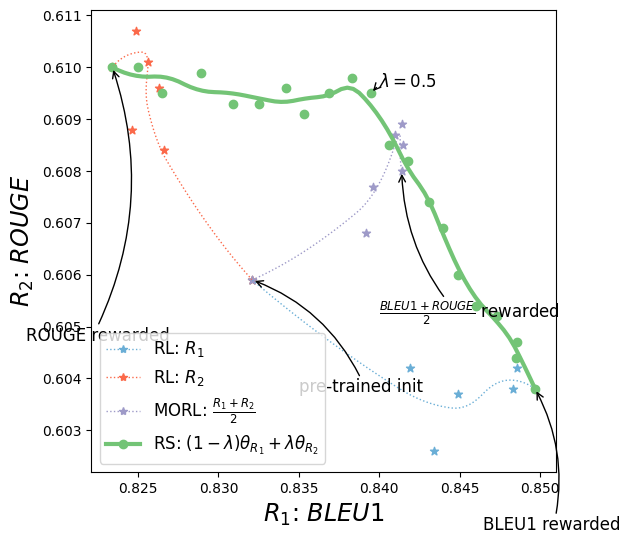

In [35]:
fig_dr = plot_captioning(
    [l_stepbleu, l_steprouge, l_stepbleurouge, l_wa_epoch5],
    key_x="Bleu_1",
    key_y="ROUGE_L",
    loc="lower left",
    do_annotate=True,
    dict_labels={
        0: r"RL: $R_1$",
        1: r"RL: $R_2$",
        2: r"MORL: $\frac{R_1+R_2}{2}$",
        3: r"RS: $(1-\lambda) \theta_{R_1} + \lambda \theta_{R_2}$"
    },
    dict_annotation_to_loc={
        "1": (0.818, 0.605),
        "lambda": (0.84, 0.6099),
        "pt": (0.835, 0.604),
        "0": (0.855, 0.601),
        "01": (0.84, 0.605)
    }
)


['$R_1$: $BLEU1$', '$BLEU2$', '$BLEU3$', '$BLEU4$', '$R_2$: $ROUGE$', '$METEOR$', '$CIDEr$']


/tmp/rame/ipykernel_525558/1948826298.py:124: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lgnd in legend.legendHandles:


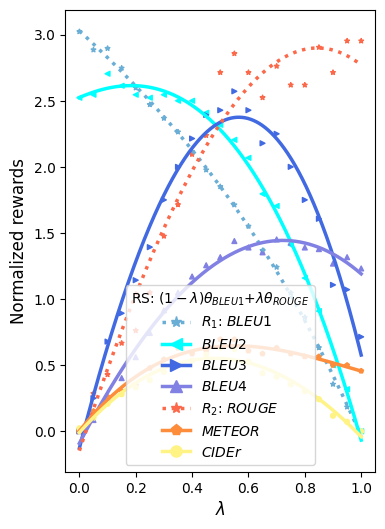

In [40]:
fig_dr = plot_scatter_captioning(
    l=l_wa_epoch5, key_1="Bleu_1", key_2="ROUGE_L", order="3", key_x="lambda",     #_dict_key_to_limit={"y": (-0.02, 1.75)},
)


In [ ]:
colors = [plot.cm.get_cmap(cmap_redpurpleblue)((9 - i) / 9) for i in range(11)]
colors+=["gold"] # plot.get_color_from_cmap("Purples", dict_colormaps)]
colors+=[plot.get_color_from_cmap("Greens", dict_colormaps)]
colors[3] = plot.cm.get_cmap("Purples")(0.5)


fig_dr = plot_captioning(
    [
        fts_bleu.l_step,
        fts_bleurouge.l_wa_91,
        fts_bleurouge.l_step_bleu4rouge1,
        fts_bleurouge.l_step_15,
        fts_bleurouge.l_step_bleu3rouge2,
        fts_bleurouge.l_step,
        fts_bleurouge.l_step_bleu2rouge3,
        fts_bleurouge.l_step_51,
        fts_bleurouge.l_step_bleu1rouge4,
        fts_bleurouge.l_wa_19,
        fts_rouge.l_step,
        l_bleurouge_multi,
        fts_bleurouge.l_wa_epoch5,
    ],
    annotate_lambda=True,
    labels=[
        r"RL $BLEU1$: $\mu=0$",
        r"MORL: $\mu=0.1$",
        r"MORL: $\mu=0.2$",
        r"MORL: $\mu=0.3$",
        r"MORL: $\mu=0.4$",
        r"MORL: $\mu=0.5$",
        r"MORL: $\mu=0.6$",
        r"MORL: $\mu=0.7$",
        r"MORL: $\mu=0.8$",
        r"MORL: $\mu=0.9$",
        r"RL $ROUGE$: $\mu=1$",
        r"MORL front",  #$(1-\mu) BLEU1$ $+$ $\mu ROUGE$",
        r"RS front",  # $(1-\lambda) \theta_{BLEU1} + \lambda \theta_{ROUGE}$"
    ],
    linestyles=[
        "dotted",
        "dashdot",
        "dashed",
        "dotted",
        "dashdot",
        "dashed",
        "dotted",
        "dashdot",
        "dashed",
        "dashdot",
        "dashed",
        "solid",
        "solid",
    ],
    linewidths=[
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        2,
        3,
    ],    
    colormaps=None,
    dict_annotation_to_loc={
        "pt": (0.835, 0.605),
        "1": (0.8236, 0.6110)
    },
    keycolor=None,
    colors=colors,
    _dict_key_to_limit={
    },
    loc="lower left",
    fontsize="medium"
)
xytext = (0.842, 0.6104)
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (0.5, 0)})

coeff = 0.1
plot.plt.annotate(
    r"$\lambda=0.1$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] - 0.001,  get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y] + 0.0005),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)

coeff = 0.2
plot.plt.annotate(
    r"$\lambda=0.2$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.001,  get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y] + 0.0005),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.3
plot.plt.annotate(
    r"$\lambda=0.3$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.001, get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y] + 0.0005),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.4
plot.plt.annotate(
    r"$\lambda=0.4$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.002, get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y] + 0.0005),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.5
xytext8=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=0.8)[key_x] + 0.002, get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=0.8)[key_y] + 0.001)
plot.plt.annotate(
    r"$\lambda=0.5$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.006, xytext8[1]),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.6
plot.plt.annotate(
    r"$\lambda=0.6$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.004, xytext8[1]),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.7
plot.plt.annotate(
    r"$\lambda=0.7$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.003, xytext8[1]),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.8
plot.plt.annotate(
    r"$\lambda=0.8$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.001, xytext8[1]),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowprops
)
coeff = 0.9
plot.plt.annotate(
    r"$\lambda=0.9$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.00, xytext8[1]),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowprops
)

